In [1]:
import os

os.makedirs("src", exist_ok=True)

In [2]:
%%writefile src/prepare_data.py

import torch, os
import pandas as pd
from pathlib import Path
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Subset
from torchvision import transforms
from PIL import Image


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, targ_dir, transform=None):
        self.image_paths = dataframe.image.values
        self.labels = dataframe.label.values
        self.transform = transform
        self.class_names_idx = create_class_names_idx(targ_dir)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        img = self.image_paths[index]
        
        # Retrieve corresponding label to image
        label_name = self.labels[index]
        
        # Instead label name (str) we need label index (int)
        label_index = self.class_names_idx[label_name]
        
        # Open img as PIL object
        img = Image.open(img).convert("RGB")
        
        # Apply transform if present
        if self.transform:
            return self.transform(img), label_index
        return img, label_index

    
def create_class_names_idx(data_dir: str):
    # Scan directory
    obj = os.scandir(data_dir)
    
    # Create class name: index dictionary
    class_names_idx = {class_name.name: i for i, class_name in enumerate(obj)}
    return class_names_idx


def create_dataloaders(targ_dir: str, test_size: float, batch_size: int, transform: transforms.Compose):
    # Set seed
    torch.manual_seed(42)
    
    # Initialize dataset before split
    if transform:
        dataset_folder = ImageFolder(root=targ_dir, transform=transform)
    else:
        dataset_folder = ImageFolder(root=targ_dir)
    class_names = dataset_folder.classes
    
    # Setup train and test size
    train_size = 1.0 - test_size
    
    # Random split data to train and test
    train_dataset, test_dataset = random_split(dataset_folder, [train_size, test_size])
    
    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader, class_names


def create_dataframe(targ_dir: str,
                     samples_per_label=None):
    # Setup list variables
    imgs, labels = [], []

    # Iterate through directories and count number of images and corresponding labels
    for p in Path(targ_dir).glob("*/*[.jpg.jpeg.png]"):
        imgs.append(p)
        labels.append(p.parent.name)

    # Create dataframe
    df = pd.DataFrame({"image": imgs, "label": labels})
    minimal_label_count = df.label.value_counts().min()
    
    # Create subset of data
    if samples_per_label:
        assert samples_per_label < minimal_label_count, "Samples per label higher than minimal label count."
        class_counts = df.label.value_counts()
        df = pd.concat([df[df['label'] == label].sample(samples_per_label) for label in class_counts.index])
    
    return df

Overwriting src/prepare_data.py


In [3]:
%%writefile src/visualize.py

import torch, random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
from pathlib import Path


def plot_labels(dataframe: pd.DataFrame):
    # Retrieve columns count as dictionary
    labels_dict = dict(dataframe["label"].value_counts())

    # Create bar plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.bar(labels_dict.keys(), labels_dict.values(), edgecolor="white");
    ax.set_xlabel("Class names")
    ax.set_ylabel("Number of images")
    ax.set_title("Number of images in each class")
    return fig

    
def plot_random_images(data_dir: str):
    # Iterate through directories and get img paths
    img_paths = list(Path(data_dir).glob("*/*[.jpg.jpeg.png]"))
    
    # Pick random images sample 
    random_imgs = random.sample(img_paths, 9)

    # Plot images in 3x3 matrix
    fig = plt.figure(figsize=(9, 9))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = Image.open(random_imgs[i])
        plt.imshow(img)
        plt.axis("off")
    return fig

        
def confusion_matrix(predictions: list, targets: list, num_classes: int, class_names: list):
    # Initialize Confusion Matrix object
    confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    
    # Move to tensor
    preds_tensor = torch.Tensor(predictions)
    targets_tensor = torch.Tensor(targets)
    
    # Pytorch Lightning Confmat
    confusion_matrix = confmat(preds_tensor, targets_tensor).numpy()
    
    # Plot confusion matrix
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix,
                                    class_names=class_names)
    return fig

Overwriting src/visualize.py


In [4]:
%%writefile src/create_model.py

import torch
from torchvision import models


def efficientnetv2_model(output_features: int, device: torch.cuda.device):
    # Initialize model object
    model = models.efficientnet_v2_s(weights="DEFAULT").to(device)
    
    # Turn off gradient computation
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify last layer to fit number of classes
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=1280, out_features=output_features, bias=True)).to(device)
    
    return model


def resnet18_model(output_features: int, device: torch.cuda.device):
    # Initialize model object
    model = models.resnet18(weights="DEFAULT").to(device)
    
    # Turn off gradient computation
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify last layer to fit number of classes
    model.fc = torch.nn.Linear(in_features=512, out_features=output_features, bias=True).to(device)
    
    return model


def resnet50_model(output_features: int, device: torch.cuda.device):
    # Initialize model object
    model = models.resnet50(weights="DEFAULT").to(device)
    
    # Turn off gradient computation
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify last layer to fit number of classes
    model.fc = torch.nn.Linear(in_features=2048, out_features=output_features, bias=True).to(device)
    
    return model

Overwriting src/create_model.py


In [5]:
%%writefile src/engine.py

import torch
import torchmetrics
import numpy as np
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn,
               optimizer: torch.optim,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.cuda.device):
    
    torch.manual_seed(42)

    # Set training mode
    model.train()
    
    # Setup loss & accuracy variables
    model_loss = 0
    model_accuracy = 0
    
    # Training batch loop
    for batch_idx, (X, y) in enumerate(train_dataloader):
        # Push data to device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)
        
        # Calculate loss & accuracy
        loss = loss_fn(y_pred, y)
        model_loss += loss.item()
        
        accuracy = accuracy_fn(y_pred, y)
        model_accuracy += accuracy
        
        # Optimizer zero-grad
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    # Adjust the metrics
    model_loss = model_loss / len(train_dataloader)
    model_accuracy = model_accuracy / len(train_dataloader)
    
    return model_loss, model_accuracy


def test_step(model: torch.nn.Module,
             test_dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn,
             accuracy_fn: torchmetrics.Accuracy,
             device: torch.cuda.device):
    
    torch.manual_seed(42)
    
    # Setup eval mode
    model.eval()
    
    # Setup loss & accuracy variables
    model_loss = 0
    model_accuracy = 0
    
    with torch.inference_mode():
        # Test batch loop
        for batch_idx, (X, y) in enumerate(test_dataloader):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss & accuracy
            loss = loss_fn(y_pred, y)
            model_loss += loss.item()

            accuracy = accuracy_fn(y_pred, y).to(device)
            model_accuracy += accuracy
    
        # Adjust the metrics
        model_loss = model_loss / len(test_dataloader)
        model_accuracy = model_accuracy / len(test_dataloader)
    
    return model_loss, model_accuracy


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn,
          optimizer: torch.optim,
          num_epochs: int,
          accuracy_fn: torchmetrics.Accuracy,
          device: torch.cuda.device):
    
    torch.manual_seed(42)
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
        
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_acc = train_step(model=model,
                                           train_dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        test_dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        tqdm.write(f'Epoch {epoch+1}/{num_epochs} - '
                   f'Train Loss: {train_loss:.4f} - '
                   f'Train Accuracy: {train_acc:.2%} - '
                   f'Validation Loss: {test_loss:.4f} - '
                   f'Validation Accuracy: {test_acc:.2%}')

    return model, results


def evaluation_model(model: torch.nn.Module,
                     test_dataloader: torch.utils.data.DataLoader,
                     device: torch.cuda.device):
    
    torch.manual_seed(42)
    
    # Setup eval mode
    model.eval()
    
    # Initialize results dictionary
    results = {"predictions": [],
               "targets": [],
               "probability": []}
    
    with torch.inference_mode():
        # Test batch loop
        for batch_idx, (X, y) in enumerate(test_dataloader):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            y_prob = torch.softmax(y_pred, dim=1)
            y_label = torch.argmax(y_prob, dim=1)

            # Append targets and predictions
            results["predictions"] += y_label.cpu()
            results["probability"] += y_prob.cpu()
            results["targets"] += y.cpu()
    results["probability"] = [prob.max() for prob in results["probability"]]
    
    return results


Overwriting src/engine.py


In [6]:
%%writefile src/utils.py

import torch, os
import pandas as pd
from pathlib import Path


def save_model(model: torch.nn.Module,
               dir_path: str,
               model_name: str):
    # Initialize Path object and create directory
    dir_path = Path(dir_path)
    dir_path.mkdir(exist_ok=True, parents=True)
    
    # Model path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_path = dir_path / model_name
    
    # Save model
    print(f"[INFO] Saving model to: {model_path}")
    torch.save(model.state_dict(), model_path)

Overwriting src/utils.py


In [7]:
%%writefile src/prediction.py

import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image


def make_prediction(model: torch.nn.Module,
                    img_path: str,
                    class_names: list,
                    device=torch.cuda.device,
                    transform=None):
    # Set PIL Image object
    img = Image.open(img_path)
    
    # Setup transform
    if transform:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
                transforms.Resize(size=(384, 384)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Perform transform
    img_tensor = image_transform(img)
        
    # Set evaluation mode
    model.eval()
    
    # Forward pass
    with torch.inference_mode():
        # Add an additional dimension (batch dimension)
        y_pred = model(img_tensor.unsqueeze(dim=0).to(device))
        
    y_prob = torch.softmax(y_pred, dim=1)
    y_label = torch.argmax(y_prob, dim=1)
    
    # Plot an image with predicted label 
    plt.figure(figsize=(3, 3))
    plt.title(f"Pred: {class_names[y_label]} | Prob: {y_prob.max():.2f}")
    plt.imshow(img)
    plt.axis("off")

Overwriting src/prediction.py


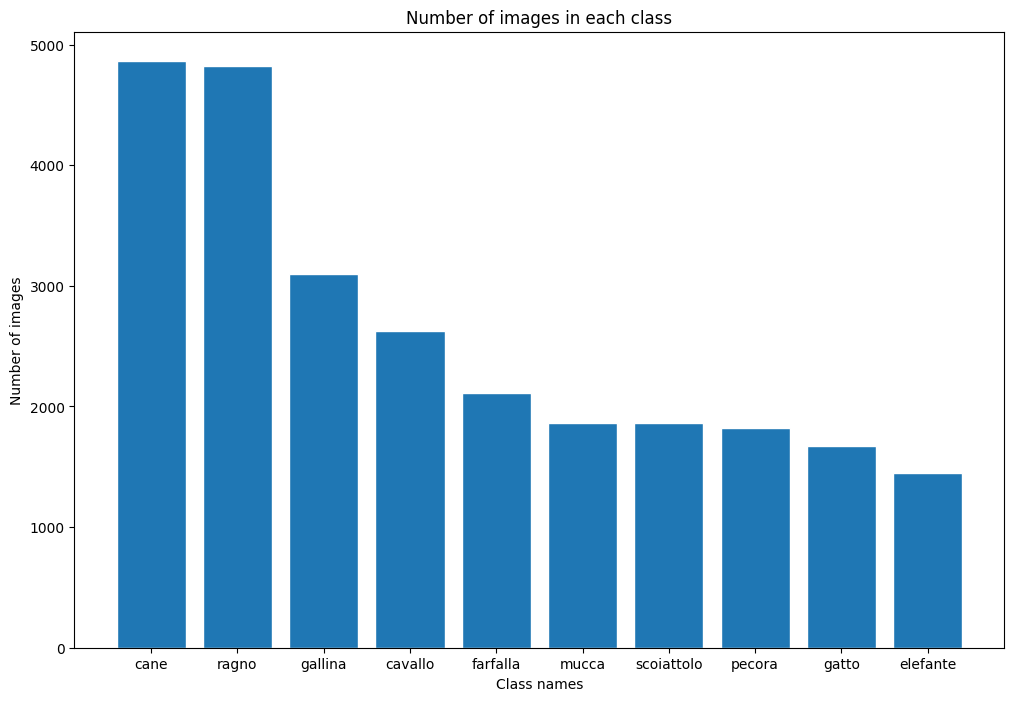

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 1.4422 - Train Accuracy: 61.11% - Validation Loss: 0.8059 - Validation Accuracy: 83.95%
Epoch 2/5 - Train Loss: 0.6438 - Train Accuracy: 86.95% - Validation Loss: 0.4929 - Validation Accuracy: 89.73%
Epoch 3/5 - Train Loss: 0.4473 - Train Accuracy: 91.07% - Validation Loss: 0.3790 - Validation Accuracy: 91.80%
Epoch 4/5 - Train Loss: 0.3576 - Train Accuracy: 92.76% - Validation Loss: 0.3237 - Validation Accuracy: 92.27%
Epoch 5/5 - Train Loss: 0.3034 - Train Accuracy: 93.50% - Validation Loss: 0.2926 - Validation Accuracy: 92.46%
[INFO] Saving model to: models/resnet18_v0.pth


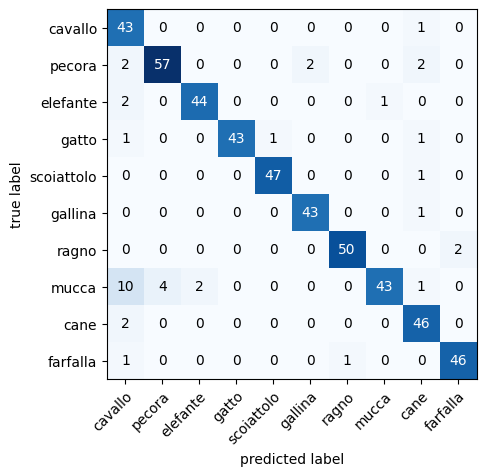

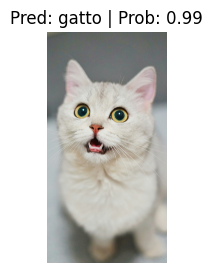

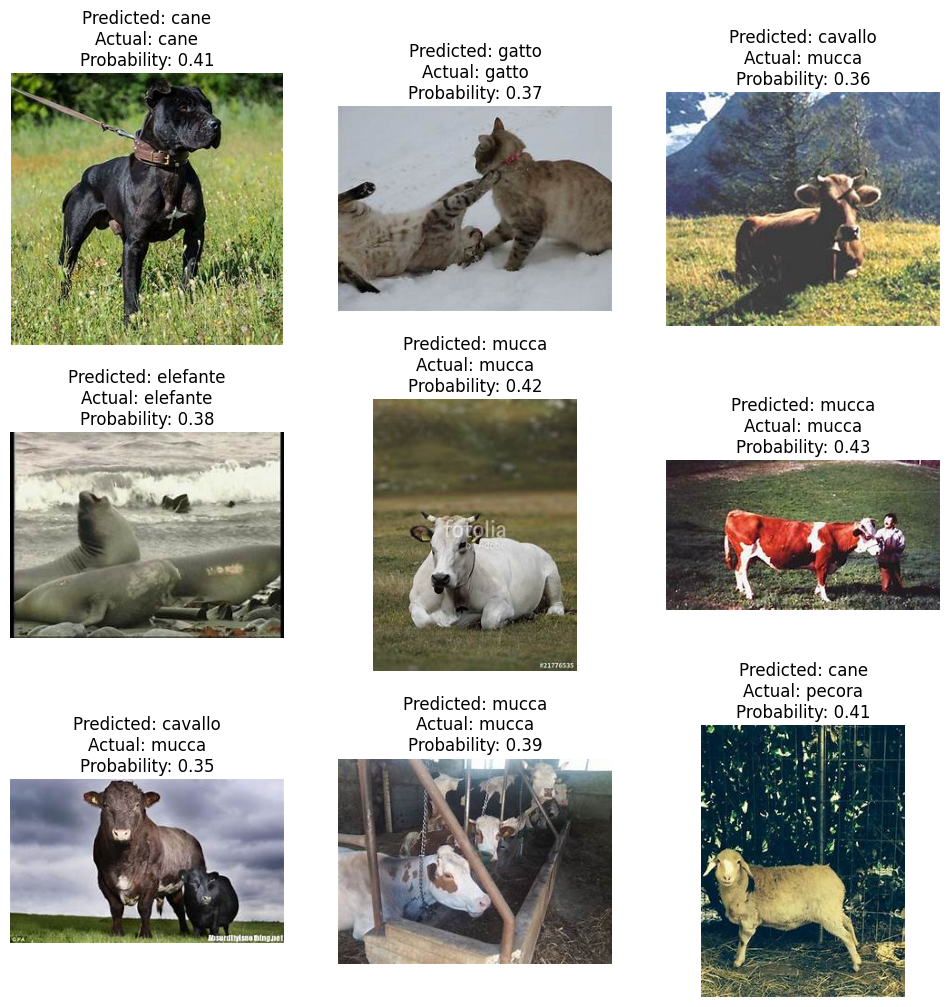

In [11]:
import torch, requests
import numpy as np
import matplotlib.pyplot as plt
import src.engine as engine
import src.prepare_data as prep_data
import src.visualize as visualize
from PIL import Image
from pathlib import Path
from src.utils import save_model
from src.prediction import make_prediction
from src.create_model import resnet18_model
from torchvision import transforms
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split 


# Set path to data (if available locally)
data_path = "/kaggle/input/animals10/raw-img"

# Setup hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
SEED = 42

# Setup transform 
transform = transforms.Compose([
    transforms.Resize(size=(384, 384)),
    transforms.CenterCrop(size=(384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Take only 250 images from every class to provide faster & balanced training
df = prep_data.create_dataframe(targ_dir=data_path, 
                                samples_per_label=250)

# Visualize the data distribution after creating dataframe subset
df_distribution = prep_data.create_dataframe(targ_dir=data_path)
fig = visualize.plot_labels(dataframe=df_distribution)
plt.show()

train_df, test_df = train_test_split(df, test_size=0.2, 
                                     random_state=SEED)

# Create Pytorch Dataset from Pandas Dataframe using custom class
train_custom_dataset = prep_data.CustomDataset(dataframe=train_df,
                                               targ_dir=data_path,
                                               transform=transform)

test_custom_dataset = prep_data.CustomDataset(dataframe=test_df,
                                              targ_dir=data_path,
                                              transform=transform)

# Create Dataloaders
train_custom_dataloader = DataLoader(dataset=train_custom_dataset, 
                                     batch_size=32, 
                                     shuffle=True)

test_custom_dataloader = DataLoader(dataset=test_custom_dataset, 
                                    batch_size=32, 
                                    shuffle=False)

# Create dictionary with class names and indexes
class_names_idx = prep_data.create_class_names_idx(data_path)
class_names = list(class_names_idx.keys())

# Device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Download and initialize model with pretrained weights
model = resnet18_model(output_features=len(class_names), 
                       device=device)

# Setup metrics, loss function and optimizer
accuracy_fn = Accuracy(task="multiclass", 
                       num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop on dataloaders
resnet18_model, metrics = engine.train(model=model,
                train_dataloader=train_custom_dataloader,
                test_dataloader=test_custom_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                num_epochs=NUM_EPOCHS,
                accuracy_fn=accuracy_fn,
                device=device)

# Set model path
model_dir_path = Path("models")

# Save model to file
save_model(model=resnet18_model,
           dir_path=model_dir_path,
           model_name="resnet18_v0.pth")

# Evaluation retrieves preds/targets for further analysis
results = engine.evaluation_model(model=resnet18_model,
                                  test_dataloader=test_custom_dataloader,
                                  device=device)

# Plot confusion matrix with corresponding classes
fig = visualize.confusion_matrix(predictions=results["predictions"], 
                           targets=results["targets"], 
                           num_classes=len(class_names),
                           class_names=class_names_idx.keys())
plt.show()

# Download custom image for prediction
request = requests.get("https://images.unsplash.com/photo-1561948955-570b270e7c36?q=80&w=2101&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
with open("unsplash_cat.jpg", "wb") as f:
    f.write(request.content)

# Make a prediction and plot image with predicted label & probability
make_prediction(model=resnet18_model,
                img_path="unsplash_cat.jpg",
                class_names=class_names,
                device=device)


# Create list containing corresponding indexes to classes in Dataframe
class_to_idx = [class_names_idx[idx] for idx in test_df.label.values]

# Copy previously created Test Dataframe
predictions_df = test_df.copy()

# Change list type elements from tensor -> numpy
predictions_numpy = np.stack(results["predictions"]) 
probabilities_numpy = np.stack(results["probability"])

# Create new columns containing indexes and results from evaluation on test data
predictions_df["labels_idx"] = class_to_idx
predictions_df["predictions"] = predictions_numpy
predictions_df["probability"] = probabilities_numpy


### Visualize predictions
# Sort probability based to visualize wrong and worst predictions
worst_predictions = predictions_df.sort_values(by=["probability"], ascending=True)[:30]

# Reverse dictionary to contain index: class_name
idx_to_class_name = dict((v,k) for k,v in class_names_idx.items())

# Get sample of 9 images
random_img_sample = worst_predictions.sample(n=9)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    
    img_data = random_img_sample.iloc[i]
    img = img_data["image"]
    img = Image.open(img)
    
    plt.imshow(img)
    plt.title(f"Predicted: {idx_to_class_name[img_data['predictions']]}\nActual: {img_data['label']}\nProbability: {img_data['probability']:.2f}")
    plt.axis("off")
plt.show()